# Lecture 3 Generative Models

This lab lesson will cover some applications of how to use knowledge acquired in pre-trained models without the need for re-training.

## Deep dream

This tutorial contains a minimal implementation of DeepDream, as described in this [blog post](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) by Alexander Mordvintsev.

DeepDream is an experiment that visualizes the patterns learned by a neural network. Similar to when a child watches clouds and tries to interpret random shapes, DeepDream over-interprets and enhances the patterns it sees in an image.

It does so by forwarding an image through the network, then calculating the gradient of the image with respect to the activations of a particular layer. The image is then modified to increase these activations, enhancing the patterns seen by the network, and resulting in a dream-like image. This process was dubbed "Inceptionism" (a reference to [InceptionNet](https://arxiv.org/pdf/1409.4842.pdf), and the [movie](https://en.wikipedia.org/wiki/Inception) Inception).

Let's demonstrate how you can make a neural network "dream" and enhance the surreal patterns it sees in an image.

In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image
import cv2
import time
import os

tf.config.run_functions_eagerly(True)

## Choose an image to dream-ify

For this tutorial, let's use an image of some [clouds](https://ec.europa.eu/research-and-innovation/sites/default/files/hm/field/image/clouds-mf.jpg).

In [2]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img, resize = None):
  out = PIL.Image.fromarray(np.array(img))
  if resize:
    out = out.resize(resize)
  display.display(out)

57344/42412 [========================================] - 0s 0us/step


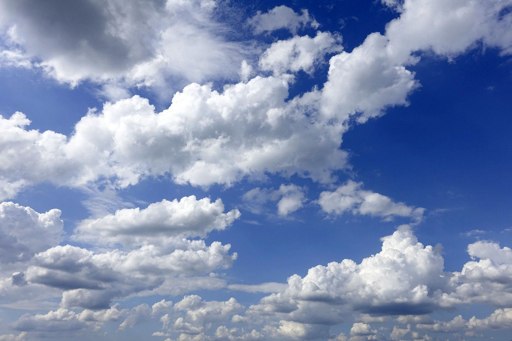

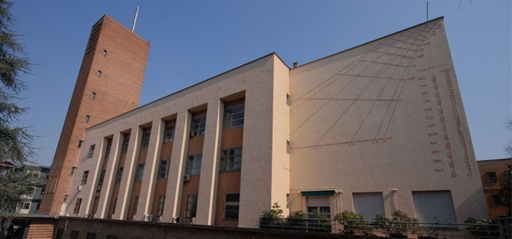

In [3]:
clouds_image_url = 'https://ec.europa.eu/research-and-innovation/sites/default/files/hm/field/image/clouds-mf.jpg'
ing_image_url = "https://www.unibo.it/it/immagini/ingegneria.jpg/@@images/d2c811fe-60e0-4dc8-acdb-48ee1c97c971.jpeg"
# Downsizing the image makes it easier to work with.
clouds_img = download(clouds_image_url, max_dim = 512)
ing_img = download(ing_image_url, max_dim = 512)
show(clouds_img)
show(ing_img)

## Prepare the feature extraction model

Download and prepare a pre-trained image classification model. You will use [InceptionV3](https://keras.io/api/applications/inceptionv3/) which is similar to the model originally used in DeepDream. Note that any [pre-trained model](https://keras.io/api/applications/#available-models) will work, although you will have to adjust the layer names below if you change this.

In [4]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87924736/87910968 [==============================] - 2s 0us/step


The idea in DeepDream is to choose a layer (or layers) and maximize the "loss" in a way that the image increasingly "excites" the layers. The complexity of the features incorporated depends on layers chosen by you, i.e, lower layers produce strokes or simple patterns, while deeper layers give sophisticated features in images, or even whole objects. <br><br>
The InceptionV3 architecture is quite large (for a graph of the model architecture see TensorFlow's [research repo](https://github.com/tensorflow/models/tree/master/research/slim)). For DeepDream, the layers of  interest are those where the convolutions are concatenated. There are 11 of these layers in InceptionV3, named 'mixed0' though 'mixed10'. Using different layers will result in different dream-like images. Deeper layers respond to higher-level features (such as eyes and faces), while earlier layers respond to simpler features (such as edges, shapes, and textures). Feel free to experiment with the layers selected below, but keep in mind that deeper layers (those with a higher index) will take longer to train on since the gradient computation is deeper.

In [47]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed4', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## Calculate loss

The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent.

In [48]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

## Gradient ascent

Once you have calculated the loss for the chosen layers, all that is left is to calculate the gradients with respect to the image, and add them to the original image. 

Adding the gradients to the image enhances the patterns seen by the network. At each step, you will have created an image that increasingly excites the activations of certain layers in the network.



The decorator `@tf.function` takes an `input_signature` to ensure that the function is not retraced for different image sizes or `steps`/`step_size` values.

In [49]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [50]:
deepdream = DeepDream(dream_model)

In [79]:
## Main Loop
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

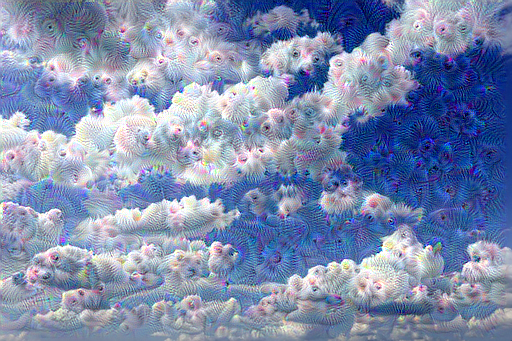

In [80]:
dream_img = run_deep_dream_simple(img=clouds_img, 
                                  steps=100, step_size=0.01)

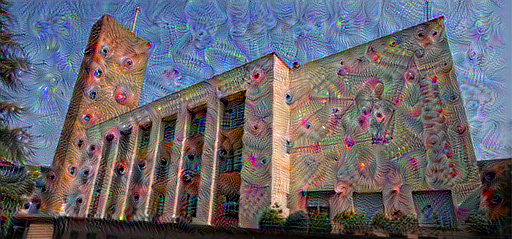

In [53]:
dream_img = run_deep_dream_simple(img=ing_img, 
                                  steps=100, step_size=0.01)

All of the patterns happens at the same scale, resulting in a noisy image. In order to extract patterns at different scale and have a more detailed output, we can apply the same technique of the gradient ascend, but at different scales. 

In [54]:
def run_deep_dream_adv(img):
  OCTAVE_SCALE = 1.3

  img = tf.constant(np.array(img))
  base_shape = tf.shape(img)[:-1]
  float_base_shape = tf.cast(base_shape, tf.float32)

  for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

    img = tf.image.resize(img, new_shape).numpy()

    img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

  display.clear_output(wait=True)
  img = tf.image.resize(img, base_shape)
  img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
  show(img)

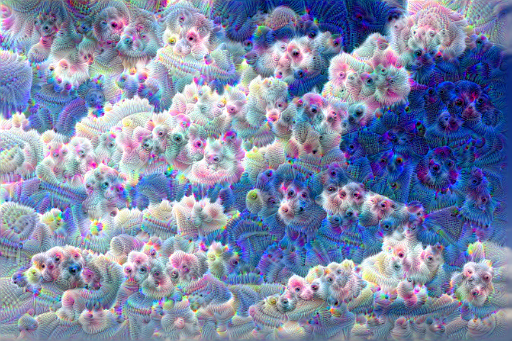

In [55]:
run_deep_dream_adv(clouds_img)

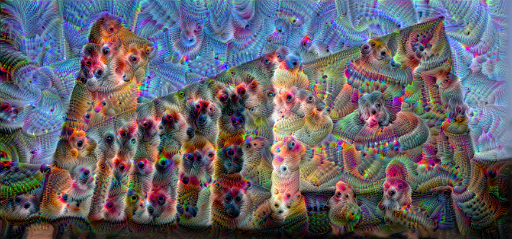

In [56]:
run_deep_dream_adv(ing_img)

## Neural style transfer

Neural style transfer is an optimization technique used to take two images—a *content* image and a *style reference* image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.
Let's start by downloading the style image.

147456/134602 [================================] - 0s 0us/step


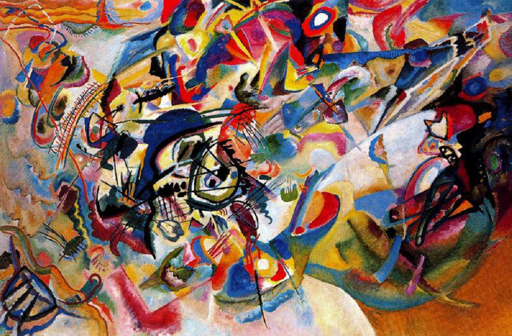

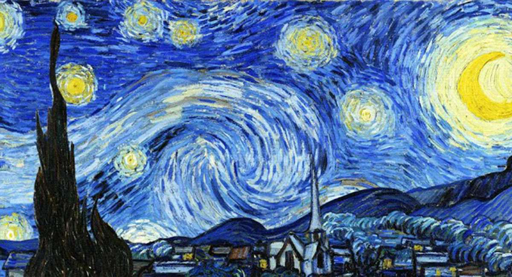

In [57]:
style_img_1 = download('https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg', max_dim = 512)
style_img_2 = download('https://assets.puzzlefactory.pl/puzzle/302/759/original.jpg', max_dim = 512)
show(style_img_1)
show(style_img_2)

## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.

For this example we won't be using the top layers of the model. We will choose intermediate layers from the network to represent the style and content of the image:


In [61]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Create the model


In [60]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

## Calculate style

The content of an image is represented by the values of the intermediate feature maps.
The style, on the other hand, can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [59]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content

Build a model that returns the style and content tensors.

In [58]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [62]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(np.expand_dims(clouds_img/255.0, axis = 0))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


80150528/80134624 [==============================] - 1s 0us/step
Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  34457.324
    mean:  585.6921

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  76887.58
    mean:  11341.754

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  554592.06
    mean:  10851.893

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  7753616.0
    mean:  158962.55

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  277088.03
    mean:  903.6051

Contents:
   block5_conv2
    shape:  (1, 21, 32, 512)
    min:  0.0
    max:  859.8399
    mean:  12.025197


## Run the transfer style algorithm

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.


In [65]:
style_weight=1e-2
content_weight=1e4

In [70]:
def style_content_loss(outputs, style_targets, content_targets):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

To make things quicker, define a function to keep the pixel values between 0 and 1 during the algorithm.

In [63]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Let's use an Adam optimizer

In [64]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Use `tf.GradientTape` to update the image.

In [66]:
@tf.function()
def train_step(image, style_img, style_targets, content_targets):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs, style_targets, content_targets)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  

In [67]:
def tensorToImage(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Let's define a function to run the algorithm. 
We will start by extracting the target style and content from the relative images, then we wrap our target image in a `tf.Variable`.

In [85]:
import time

def run_transfer_style(content_img, style_img):
  start = time.time()
  image = np.expand_dims(content_img/255.0, axis = 0)
  style = np.expand_dims(style_img/255.0, axis = 0)
  style_targets = extractor(style)['style']
  content_targets = extractor(image)['content']
  epochs = 500

  image = tf.Variable(image, dtype = tf.float32)
  style = tf.Variable(style, dtype = tf.float32)
  for n in range(epochs):
    train_step(image, style, style_targets, content_targets)
    display.clear_output(wait=True)
    display.display(tensorToImage(image))
    print(f"Epoch: {n}")
    
  end = time.time()
  print("Total time: {:.1f}".format(end-start))

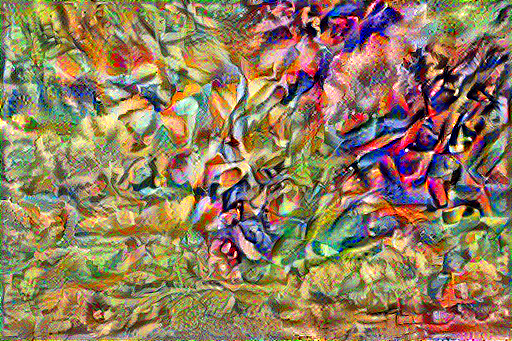

Epoch: 499
Total time: 181.0


In [86]:
run_transfer_style(clouds_img, style_img_1)

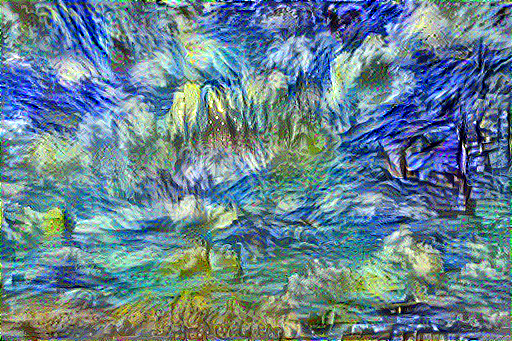

Epoch: 499
Total time: 180.6


In [87]:
run_transfer_style(clouds_img, style_img_2)

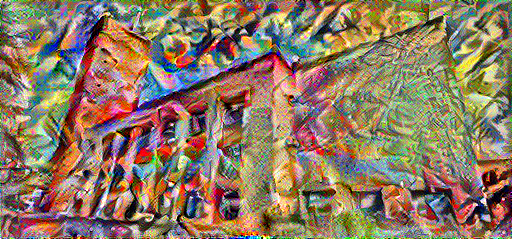

Epoch: 499
Total time: 135.2


In [88]:
run_transfer_style(ing_img, style_img_1)

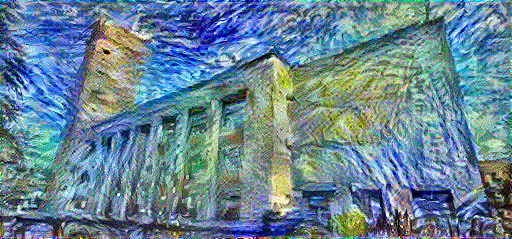

Epoch: 499
Total time: 135.2


In [89]:
run_transfer_style(ing_img, style_img_2)